# Correlations between predictions of Linear vs. Nonlinear Regression Models


Paul A.  Bloom, January 2020

This notebook compares predicted values on a test set for random forest, support vector, ridge, and ensemble regression models fit to the same training set to evaluate the similarity of their predictions. It outputs a correlation matrix plot of the predictions on the test set.

# Load libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge

# Run regression models on SCARED-P


- Run random forest regression, ridge regression, support vector regression, and ensemble models to compare their predictions

In [2]:
# Load in HBN data
hbn = pd.read_csv('../../cleanData/fullHBN.csv')

# drop extra variables and NAs
hbn = hbn.drop(['Identifiers', 'scaredSumChild', 'scaredBinChild', 'ksadsBin','scaredBinParent','ageCenter','cbclGISum'], 1).dropna(axis = 0)
hbn.reset_index(inplace = True, drop = True)
X = hbn.drop(['scaredSumParent'], axis = 1)

# scale
scaler = sk.preprocessing.StandardScaler().fit(X)
X_columns = X.columns
X = scaler.transform(X)
y = hbn['scaredSumParent']
hbn.head()

# Params for random forest tuning
max_depths = [2,3]
max_features = [2,3]
min_samps = [10,15,20]

param_grid_forest = [{'max_features': max_features,
               'max_depth': max_depths,
                'min_samples_leaf': min_samps}]



#T rain/test split and save scores of each model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, 
                                                    random_state = 340183)

# Set up models
forest_reg =  RandomForestRegressor(n_estimators = 50)
svr_reg = SVR(kernel = 'rbf', gamma = 'auto')
ridge_reg = Ridge()

# CV for forest 
forest_cv = GridSearchCV(forest_reg, param_grid_forest, cv = 3) 

# Voting regressor
voter_reg = VotingRegressor(estimators = [('svm', svr_reg), 
                                           ('forest', forest_reg),
                                           ('log', ridge_reg)])

# Fit each model
forestFit = forest_cv.fit(X_train, y_train)
svrFit = svr_reg.fit(X_train, y_train)
ridgeFit = ridge_reg.fit(X_train, y_train)
voterFit = voter_reg.fit(X_train, y_train)

# Generate predictions for each model
forestPredTest = forestFit.predict(X_test)
svrPredTest = svrFit.predict(X_test)
ridgePredTest = ridgeFit.predict(X_test)
voterPredTest = voterFit.predict(X_test)



# Pull predicted values and true outcomes on test set 

In [3]:
# Make one data frame of predicted and actual values for test set
predFrame = pd.DataFrame({
    'Random Forest':forestPredTest,
    'SVR':svrPredTest,
    'Ridge':ridgePredTest,
    'Ensemble': voterPredTest,
    'SCARED-P True Values': y_test
})

In [4]:
predFrame.head()

,Ensemble,Random Forest,Ridge,SCARED-P True Values,SVR
1136,12.088475,11.611441,11.269672,28.0,9.255752
1122,10.154642,11.508471,10.760680,2.0,9.263247
477,8.515810,11.611441,11.345852,35.0,9.201577
1430,34.126887,30.624849,31.971234,20.0,21.069428
704,12.680104,11.278604,10.425848,25.0,10.074465


# Correlations among predictions across model types

In [5]:
corMat = predFrame.corr()

## Plot correlation matrix of predictions and actual values

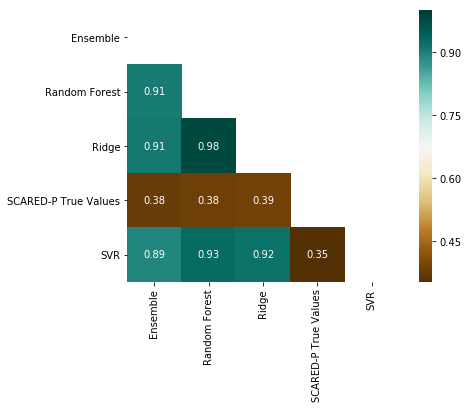

In [6]:
cmap = "BrBG"
mask = np.zeros_like(corMat)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(7, 5))
ax = sns.heatmap(corMat, mask=mask, cmap = cmap, annot = True, square=True)
    
fig = ax.get_figure()
fig.savefig('../../plots/nonlinearCorrelations.png', dpi = 300, bbox_inches = 'tight', height = 8, width = 4)